<a href="https://colab.research.google.com/github/blakeobeans/kaggle_notebooks/blob/master/Titanic_w_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt

### Mount Google Drive

In [3]:
from google.colab import drive
import os
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#set wd
path = '/content/drive/My Drive/Colab Notebooks/Kaggle/Titanic'
os.chdir(path)
path

'/content/drive/My Drive/Colab Notebooks/Kaggle/Titanic'

In [0]:
from google.colab import files

### Set API Creds

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "blakeobeans"

In [0]:
#note- enter API key here
os.environ['KAGGLE_KEY'] = open("api_key.txt").read()

### Download Data

In [0]:
!kaggle competitions download -c titanic

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


### Import Data

In [0]:
import pandas as pd

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Exploratory Analysis

In [0]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
train.shape

(891, 12)

In [0]:
test.shape

(418, 11)

## Feature Engineering

### Data Concatenation

In [0]:
train_labels = train['Survived'] #resume working with labels in section  "Splitting Data"

In [0]:
train = train.drop(['Survived'], axis = 1)

In [0]:
df = pd.concat([train, test], axis = 0)

In [0]:
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Remove irrelevant variables

In [0]:
#Removing 'PassengerID'
df = df.drop(['PassengerId'], axis = 1)

### Missing Data Imputation

In [0]:
df.isna().sum()

Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

Missing data for age, fare, cabin and embarked.

In [0]:
df.corr()

,Pclass,Age,SibSp,Parch,Fare
Pclass,1.000000,-0.408106,0.060832,0.018322,-0.558629
Age,-0.408106,1.000000,-0.243699,-0.150917,0.178740
SibSp,0.060832,-0.243699,1.000000,0.373587,0.160238
Parch,0.018322,-0.150917,0.373587,1.000000,0.221539
Fare,-0.558629,0.178740,0.160238,0.221539,1.000000


#### 'Age'

Age is most closely correlated with Pclass and SibSp, so we'll impute after grouping by these two variables.

In [0]:
#df.groupby(['Pclass', 'SibSp']).median()['Age']
df['Age'] = df.groupby(['Pclass', 'SibSp'])['Age'].transform(lambda x: x.fillna(x.median()))

#### 'Embarked'

In [0]:
#Googling identifies passenger by name- departed from Southampton
df['Embarked'] = df['Embarked'].fillna('S')

#### 'Fare'

In [0]:
df[df['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [0]:
#most closely correlated with Pclass, Parch and Age
#group by Pclass only because no match for Parch and Age
df.groupby(['Pclass', 'Parch', 'Age']).median()['Fare']
df['Fare'] = df.groupby(['Pclass'])['Fare'].transform(lambda x: x.fillna(x.median()))

#### 'Cabin'

In [0]:
#create a deck column from the first letter of the cabin column
df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

In [0]:
df['Deck'] = df['Deck'].replace(['A', 'B', 'C', 'T'], 'ABC')
df['Deck'] = df['Deck'].replace(['D', 'E'], 'DE')
df['Deck'] = df['Deck'].replace(['F', 'G'], 'FG')

In [0]:
df = df.drop(['Cabin'], axis = 1)

### Frequency Encoding

#### 'Family Size'

In [0]:
df['Family_Size'] = df['SibSp'] + df['Parch'] + 1

#### 'Ticket Frequency'

In [0]:
df['Ticket_Frequency'] = df.groupby('Ticket')['Ticket'].transform('count')

#### 'Is_Married' (woman only)

In [0]:
df['Title'] = df['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df['Is_Married'] = 0
df['Is_Married'].loc[df['Title'] == 'Mrs'] = 1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


#### 'Title'

In [0]:
df['Title'] = df['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df['Title'] = df['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

### Categorical Encoding

Because the XGBoost algorithm requires numeric value, we have to main options for dealing with categorical variables: **label encoding** and **one-hot encoding**.  
I'll opt for label encoding where there is an inherent rank and one-hot encoding otherwise.

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 14 columns):
Pclass              1309 non-null int64
Name                1309 non-null object
Sex                 1309 non-null object
Age                 1309 non-null float64
SibSp               1309 non-null int64
Parch               1309 non-null int64
Ticket              1309 non-null object
Fare                1309 non-null float64
Embarked            1309 non-null object
Deck                1309 non-null object
Family_Size         1309 non-null int64
Ticket_Frequency    1309 non-null int64
Title               1309 non-null object
Is_Married          1309 non-null int64
dtypes: float64(2), int64(6), object(6)
memory usage: 153.4+ KB


**Label encoding**: Pclass  
**One-hot encoding**: Sex, Embarked

In [0]:
df_cat_ohe = df[['Sex', 'Embarked', 'Deck']]
df_cat_le = df[['Pclass']]
df_quant = df[['Age', 'SibSp', 'Parch', 'Fare']]

#### Label Encoding

Label encoding can be done with pandas

In [0]:
df_cat_le['Pclass'] = pd.to_numeric(df_cat_le['Pclass']) # Replace strings with an integer

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### One-hot encoding

In [0]:
df_cat_ohe.Sex.unique()

array(['male', 'female'], dtype=object)

In [0]:
df_cat_ohe.Embarked.unique()

array(['S', 'C', 'Q'], dtype=object)

In [0]:
df_cat_ohe.Deck.unique()

array(['M', 'ABC', 'DE', 'FG'], dtype=object)

In [0]:
from sklearn import preprocessing

In [0]:
enc = preprocessing.OneHotEncoder()
enc.fit(df_cat_ohe)
onehotlabels = enc.transform(df_cat_ohe).toarray()
df_ohe = pd.DataFrame(onehotlabels)
df_ohe.columns = ['M', 'F', 'S', 'C', 'Q', 'D_M', 'D_ABC', 'D_E', 'D_FG']

### Ticket and Name- To Be Continued

### Joining Data Frame

In [0]:
df = pd.concat([df_quant, df_cat_le], axis=1, sort=False)

In [0]:
df = df.reset_index(drop = False)

In [0]:
df_ohe = df_ohe.reset_index(drop = False)

In [0]:
df = df.join(df_ohe.set_index('index'), on = 'index')

In [0]:
df = df.drop(['index'], axis = 1)

## XGBoost with Grid Search and Cross Validation with Scikit-learn API

The XGBoost library does not have a grid search function, so we will use the scikit-learn API for XGBoost instead. 

### Splitting Data

#### Train and Test Set

In [0]:
train_features = df.iloc[0:890,:]
test_features = df.iloc[891:1310,:]

In [0]:
train_features.shape

(890, 14)

In [0]:
test_features.shape

(418, 14)

In [0]:
train = pd.concat([train_features, train_labels], axis=1, sort=False)

#### Validation Data for Cross-Validation

##### Note: hyperparameter tuning starts below

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
split_percent = 0.1 #adjustable
train, val = train_test_split(train, test_size=split_percent, stratify = train['Survived'], random_state=135) 

In [0]:
train_labels = train['Survived']
val_labels = val['Survived']

In [0]:
train_features = train.drop('Survived', axis = 1)
val_features = val.drop('Survived', axis = 1)

### Define Model

In [0]:
from xgboost import XGBClassifier

In [0]:
model = XGBClassifier()

### Set Parameters

In [0]:
#original parameters
params = {
     'colsample_bytree': [0.6, 0.8, 1.0], #fraction of features to use
     'gamma': [0.5, 1, 1.5, 2, 5],
     'learning_rate' : [0.01, 0.1, 0.3], #learning rate
     'max_depth': [3, 4, 5], #number of allowable nodes
     'min_child_weight': [1, 3, 5], #weight required for new node
     'n_estimators' : [50, 100, 200], #number of trees 
     'subsample': [0.6, 0.8, 1.0] #fraction of rows to subsample
}

In [0]:
params #most recent parameters

{'colsample_bytree': [0.6, 0.8, 1.0],
 'gamma': [0.5, 1, 1.5, 2, 5],
 'learning_rate': [0.01, 0.1, 0.3],
 'max_depth': [3, 4, 5],
 'min_child_weight': [1, 3, 5],
 'n_estimators': [50, 100, 200],
 'subsample': [0.6, 0.8, 1.0]}

In [0]:
grid_search.best_params_

{'colsample_bytree': 0.9,
 'gamma': 1.1,
 'learning_rate': 0.3,
 'max_depth': 8,
 'min_child_weight': 1,
 'n_estimators': 18,
 'subsample': 0.6}

In [0]:
#new parameters
params = {
     'colsample_bytree': [0.8, 0.9, 1.0], #fraction of features to use
     'gamma': [1.0, 1.1, 1.2],
     'learning_rate' : [0.2, 0.3, 0.4], #learning rate
     'max_depth': [7, 8, 9], #number of allowable nodes
     'min_child_weight': [1, 2], #weight required for new node
     'n_estimators' : [15, 18, 20], #number of trees 
     'subsample': [0.5, 0.6, 0.7] #fraction of rows to subsample
}

### Set Up Cross Validation

In [0]:
from sklearn.model_selection import StratifiedKFold

In [0]:
folds = 5
random_state = 3259
skf = StratifiedKFold(n_splits = folds, 
                      shuffle = True, 
                      random_state = random_state)

### Define Validation Parameter

In [0]:
eval_set = [(val_features, val_labels)]

### Create Grid Search Model Object

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
grid_search = GridSearchCV(model, 
                           params, 
                           scoring='accuracy', 
                           n_jobs=-1, 
                           cv=skf, 
                           verbose = 3,
                           return_train_score = True)

### Fit Model

In [0]:
#trained with the evaluation set to prevent overfitting
grid_search.fit(X = train_features, 
                y = train_labels,
                eval_set = eval_set,
                eval_metric = "error",
                early_stopping_rounds = 25)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1074 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 1970 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 3122 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 4530 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 6194 tasks      | elapsed:  1.8min


[0]	validation_0-error:0.24
Will train until validation_0-error hasn't improved in 25 rounds.
[1]	validation_0-error:0.24
[2]	validation_0-error:0.24
[3]	validation_0-error:0.24
[4]	validation_0-error:0.24
[5]	validation_0-error:0.24
[6]	validation_0-error:0.24
[7]	validation_0-error:0.24
[8]	validation_0-error:0.24
[9]	validation_0-error:0.24
[10]	validation_0-error:0.24
[11]	validation_0-error:0.24
[12]	validation_0-error:0.24
[13]	validation_0-error:0.24
[14]	validation_0-error:0.24


[Parallel(n_jobs=-1)]: Done 7290 out of 7290 | elapsed:  2.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3259, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:l...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [1.0, 1.1, 1.2],
                         'learning_rate': [0.2, 0.3, 0.4],
                     

## Analyze Model

### Review Best Grid Scores

In [0]:
1-grid_search.best_score_

0.19725158562367862

In [0]:
grid_search.best_params_

{'colsample_bytree': 0.8,
 'gamma': 1.2,
 'learning_rate': 0.2,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 15,
 'subsample': 0.7}

In [0]:
params

{'colsample_bytree': [0.8, 0.9, 1.0],
 'gamma': [1.0, 1.1, 1.2],
 'learning_rate': [0.2, 0.3, 0.4],
 'max_depth': [7, 8, 9],
 'min_child_weight': [1, 2],
 'n_estimators': [15, 18, 20],
 'subsample': [0.5, 0.6, 0.7]}

### Tuning Hyperparameters

If the optimum hyperparameter is on a lower or upper bound, include smaller/larger parameters and search again. (Just adjust the grid search parameters in the previous section.)

## Final Model Using XGBoost API

In [0]:
import xgboost as xgb

### Create XGBoost Dataframes

In [0]:
dtrain = xgb.DMatrix(train_features, label=train_labels)
dval = xgb.DMatrix(val_features, label=val_labels)
dtest = xgb.DMatrix(test_features)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### Create Model Object

In [0]:
cv_xgb = xgb.cv(params = grid_search.best_params_, #using best params from scikit-learn model
                dtrain = dtrain, 
                nfold = 5,
                metrics = ['error'], 
                early_stopping_rounds = 5) # Look for early stopping that minimizes error

In [0]:
cv_xgb.tail()

,train-error-mean,train-error-std,test-error-mean,test-error-std
5,0.147915,0.020175,0.210994,0.052873
6,0.154765,0.026108,0.252220,0.067118
7,0.155915,0.024127,0.252220,0.067118
8,0.155921,0.029956,0.220190,0.059054
9,0.153616,0.029225,0.220190,0.059054


### Train Model

In [0]:
bst = xgb.train(grid_search.best_params_, 
                dtrain, 
                evals = [(dval, "Validation")],
                early_stopping_rounds = 25)

[0]	Validation-rmse:0.462778
Will train until Validation-rmse hasn't improved in 25 rounds.
[1]	Validation-rmse:0.432156
[2]	Validation-rmse:0.422408
[3]	Validation-rmse:0.401908
[4]	Validation-rmse:0.401107
[5]	Validation-rmse:0.404563
[6]	Validation-rmse:0.402746
[7]	Validation-rmse:0.40866
[8]	Validation-rmse:0.408823
[9]	Validation-rmse:0.408734


### Importance Plot

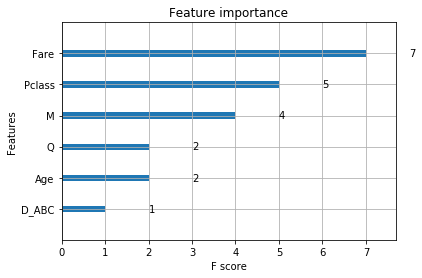

In [0]:
xgb.plot_importance(bst)

### Tree Plot

In [0]:
from xgboost import plot_tree

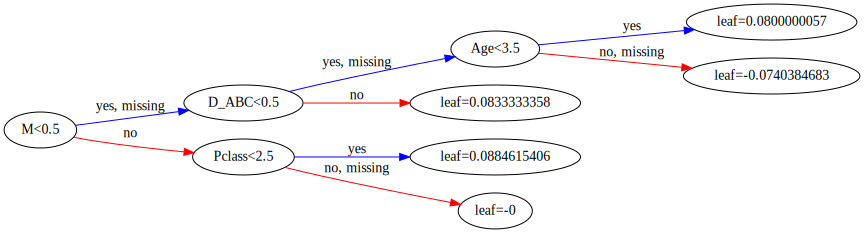

In [0]:
xgb.to_graphviz(bst, rankdir='LR')

### ROC Curve/Threshold

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [0]:
lr_probs = bst.predict(dval)

In [0]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(val_labels))]

In [0]:
# calculate scores
ns_auc = roc_auc_score(val_labels, ns_probs)
lr_auc = roc_auc_score(val_labels, lr_probs)

In [0]:
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBoost: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.843


In [0]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(val_labels, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(val_labels, lr_probs)

In [0]:
from matplotlib import pyplot

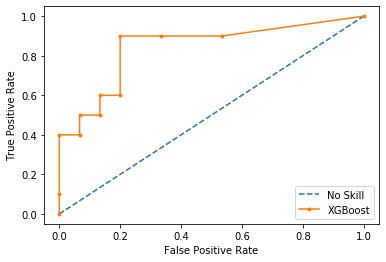

In [0]:
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Making Predictions

In [0]:
y_pred = bst.predict(dtest)

In [0]:
import numpy as np

In [0]:
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.asarray(y_pred)

In [0]:
test = pd.read_csv('test.csv')

In [0]:
submission = pd.DataFrame(
    {"PassengerID": test.iloc[:,0],
     "Survived": y_pred}
)

### Saving Predictions

In [0]:
from numpy import asarray
from numpy import savetxt
savetxt('submission_17.csv', submission, delimiter=',') # save to csv file
submission.to_csv("submission_17.csv", index = False)

### Submitting via Kaggle API

In [26]:
!kaggle competitions submit -c titanic -f submission_17.csv -m 'testing'

100% 2.77k/2.77k [00:02<00:00, 1.06kB/s]
403 - Your team has used its submission allowance (10 of 10). This resets at midnight UTC (8.2 hours from now).


In [25]:
!kaggle competitions submissions -c titanic

fileName           date                 description                    status    publicScore  privateScore  
-----------------  -------------------  -----------------------------  --------  -----------  ------------  
submission_17.csv  2020-03-14 15:50:04  updated grid search            complete  0.66028      None          
submission_17.csv  2020-03-14 03:40:11  updated grid search            complete  0.66028      None          
submission_17.csv  2020-03-14 03:39:53  updated grid search            complete  0.66028      None          
submission_17.csv  2020-03-14 03:39:31  updated grid search            complete  0.66028      None          
submission_17.csv  2020-03-14 03:38:58  updated grid search            complete  0.66028      None          
submission_16.csv  2020-03-14 01:07:27  playing with label thresholds  complete  0.63636      None          
submission_17.csv  2020-03-14 00:33:43  playing with class threholds   complete  0.78947      None          
submission_17.csv  